# Conditional Inference

In [1]:
%matplotlib inline
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.sandbox.stats.runs as sssr
import statsmodels.stats.proportion as ssp
from scipy import optimize, stats

In [2]:
sns.set(color_codes=True)

## Estimating the Width of the Room Revised

_The unconditional analysis of the room width estimated by two groups of students in Chapter 3 led to the conclusion that the estimates in meters are slightly larger than the estimates in feet. Here, we reanalyze these data in a conditional framework._

In [3]:
roomwidth = pd.read_csv('roomwidth.csv')
del roomwidth['Unnamed: 0']
roomwidth.head()

,unit,width
0,metres,8
1,metres,9
2,metres,10
3,metres,10
4,metres,10


In [4]:
def convert(row):
    if row['unit'] == 'metres':
        row['width'] *= 3.28
    return row

roomwidth = roomwidth.apply(convert, axis=1)
roomwidth.head()

,unit,width
0,metres,26.24
1,metres,29.52
2,metres,32.80
3,metres,32.80
4,metres,32.80


In [5]:
feet = roomwidth['unit'] == 'feet'
metres = roomwidth['unit'] == 'metres'
T = roomwidth[feet]['width'].mean() - roomwidth[metres]['width'].mean()
T

-8.858893280632401

_In order to approximate the conditional distribution of the test statistic T we compute thousands of test statistics for shuffled $roomwidth$ values._

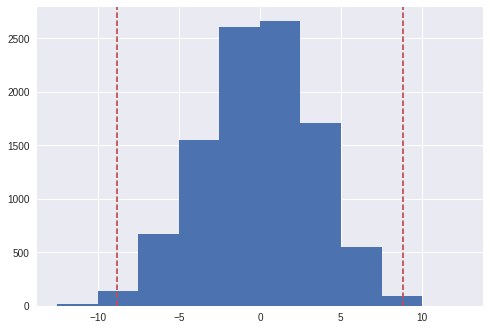

In [6]:
meandiffs = []
for idx in range(9999):
    sy = roomwidth.sample(n=len(roomwidth))
    sy = sy.reset_index()
    meandiffs.append(sy[feet]['width'].mean() - sy[metres]['width'].mean())
    
meandiffs = pd.Series(meandiffs)
meandiffs.hist()
plt.axvline(x=T, color='r', linestyle='dashed')
plt.axvline(x=-T, color='r', linestyle='dashed')


In [7]:
greater = np.abs(meandiffs) > np.abs(T)
greater.mean()

0.0073007300730073008

In [8]:
pvalue = stats.binom_test(np.sum(greater), len(greater))

print("binomial test p-value:", pvalue)

binomial test p-value: 4.94065645841e-324


In [9]:
ssp.proportion_confint(np.sum(greater), len(greater))

(0.0056320933241582492, 0.0089693668218563515)

In [10]:
def wilcoxon_cint(x, y):
    """
    An attempt to calculate confidence interval of Wilcoxon test, based on it's R implementation:
    https://github.com/wch/r-source/blob/trunk/src/library/stats/R/wilcox.test.R
    """
    n = len(x)
    mu = 0
    conf_level = 0.95
    exact = len(x) < 50

    r = stats.rankdata((x - mu).append(y))
    n_x = len(x)
    n_y = len(y)
    exact = (n_x < 50) and (n_y < 5)
    statistic = np.sum(r[0:n_x]) - n_x * (n_x + 1) / 2
    ties = (len(r) != len(np.unique(r)))

    # https://github.com/wch/r-source/blob/trunk/src/library/stats/R/wilcox.test.R#L332
    nties = pd.Series(r).value_counts()
    z = statistic - (n_x * n_y / 2)
    sigma = np.sqrt((n_x * n_y / 12) *
                    ((n_x + n_y + 1)
                   - np.sum(np.power(nties, 3) - nties)
                    / ((n_x + n_y) * (n_x + n_y - 1))))
    correction = np.sign(z) * 0.5
    z = (z - correction) / sigma
    pval = 2 * min(stats.norm.cdf(z), stats.norm.cdf((1 - z) / 2))

    # conf.int
    alpha = 1 - conf_level
    mumin = x.min() - y.max()
    mumax = x.max() - y.min()

    def W(d):
        dr = stats.rankdata((x - d).append(y))
        nties_ci = pd.Series(r).value_counts()
        dz = np.sum(dr[0:n_x]) - n_x * (n_x + 1) / 2 - n_x * n_y / 2
        correction_ci = np.sign(dz) * 0.5
        sigma_ci = np.sqrt((n_x * n_y / 12) *
                               ((n_x + n_y + 1)
                             - sum(np.power(nties_ci, 3) - nties_ci)
                             / ((n_x + n_y) * (n_x + n_y - 1))))
        return (dz - correction_ci) / sigma_ci

    def wdiff(d, zq):
        val = W(d) - zq
        return val
    
    Wmumin = W(mumin)
    Wmumax = W(mumax)

    def root(zq):
        lower = Wmumin - zq
        if lower <= 0:
            return mumin
        upper = Wmumax - zq
        if upper >= 0:
            return mumax
        return optimize.brentq(wdiff, a=mumin, b=mumax, args=(zq,))

    l = root(zq=stats.norm.ppf(1 - alpha / 2))
    u = root(zq=stats.norm.ppf(alpha / 2))
    
    return pval, (l, u)

pvalue, (cl, cu) = wilcoxon_cint(roomwidth[feet]['width'], roomwidth[metres]['width'])

print("p-value:", pvalue)
print("confidence interval: ", cl, cu)

p-value: 0.0281547888151
confidence interval:  -9.359999999999618 -0.8000000000008245


_Based on the results of the permutation test applied to the $roomwidth$ data we can conclude that the estimates in meters are, on average, larger than the estimates in feet._

## Crowds and Threatened Suicide


_The data in this case are in the form of 2x2 contingency table and it might be thought that the chi-squared test could again be applied to test for the independence of crowd behavior and time of year. However, the chi-squared distribution as an approximation to the independence test statistic is bad when the expected frequencies are rather small. One solution is to use a conditional test procedure such as Fisher's exact test._

In [11]:
suicides = pd.read_csv('suicides.csv')
suicides.rename(index=str, columns={'Unnamed: 0': 'season'}, inplace=True)
suicides = suicides.set_index('season')
suicides.head()

,Baiting,Nonbaiting
season,,
June--September,8,4
October--May,2,7


In [12]:
statistic, pvalue = stats.fisher_exact(suicides)

print("statistic", statistic, "p-value", pvalue)

statistic 7.0 p-value 0.0804953560372


_There is no strong evidence of crowd behavior being associated with time of year of threatened suicide, but the sample size is low and the test lacks power._

## Gastrointestinal Damage

_Here we are interested in the comparison of two groups of patients, where one group received a placebo and the other one Misoprostol. In the trials shown here, the response variable is measured on an ordered scale. Data from four clinical studies are available and thus the observation are naturally grouped together._

In [13]:
lanza = pd.read_csv('Lanza.csv')
del lanza['Unnamed: 0']
lanza.head()

,study,treatment,classification
0,I,Misoprostol,1
1,I,Misoprostol,1
2,I,Misoprostol,1
3,I,Misoprostol,1
4,I,Misoprostol,1


In [22]:
pivotlanza = lanza.pivot_table(
    columns='classification', 
    index=['study', 'treatment'],
    aggfunc=lambda x: len(x),
    fill_value=0,
)
pivotlanza

classification      1  2  3  4   5
study treatment                   
I     Misoprostol  21  2  4  2   0
      Placebo       2  2  4  9  13
II    Misoprostol  20  4  6  0   0
      Placebo       8  4  9  4   5
III   Misoprostol  20  4  3  1   2
      Placebo       0  2  5  5  17
IV    Misoprostol   1  4  5  0   0
      Placebo       0  0  0  4   6